# Summarize burst rate and spectrogram using group mean

(burst events were detected using old method)


### Code:

In [1]:
import numpy as np
import os
from ECoGBurst import SpectralBurst
from functools import reduce
import matplotlib.pyplot as plt

In [2]:
#~~~~~~~~~~~~set up basic variables~~~~~~~~~~~~~~~~~~
# all subjects info
sbj_ls = ['YBE','YBG','YBI','YBJ','YBN','YCP']

tone_blk_dict = {'YBE' : ['016'], 'YBG' : ['006'], 'YBI' : ['013'],
                'YBJ' : ['009'], 'YBN' : ['036'], 'YCP' : ['035']}

recall_blk_dict = {'YBE' : ['011','018'], 'YBG' : ['007','008','009'],
                'YBI' : ['014'], 'YBJ' : ['010'], 
                'YBN' : ['038', '039', '040'], 'YCP' : ['038', '039']}

# home directory
home_path = '~/Documents/MATLAB/ECoG'
home_dir  = os.path.expanduser(home_path)

# initiate all burst object
burst_tone_dict   = {}
burst_recall_dict = {}

for sj in sbj_ls:
    burst_tone_obj   = SpectralBurst(sbj_name = sj, 
                               blk_name = tone_blk_dict[sj], 
                               task_name = 'vis_tone_only')
    burst_recall_obj = SpectralBurst(sbj_name = sj,
                               blk_name = recall_blk_dict[sj],
                               task_name = 'vis_contrast_recall')
    
    burst_tone_dict[sj] = burst_tone_obj
    burst_recall_dict[sj] = burst_recall_obj
    
# get visual cortex electrodes and visual responsive electrodes
elec_vis_dict, elec_resp_dict = {}, {}

for sj in sbj_ls:
    burst_tone_obj   = burst_tone_dict[sj]
    burst_recall_obj = burst_recall_dict[sj]
    
    elec_vis_tone    = burst_tone_obj.select_channel()
    elec_vis_recall  = burst_recall_obj.select_channel()
    
    elec_vis_select = reduce(np.intersect1d, (elec_vis_tone, elec_vis_recall))
    elec_vis_dict[sj] = elec_vis_select.astype(int).tolist()

    elec_resp_tone    = burst_tone_obj.select_channel(elec_type = 'resp')
    elec_resp_recall  = burst_recall_obj.select_channel(elec_type = 'resp')
    
    elec_resp_select   = reduce(np.intersect1d, (elec_resp_tone, elec_resp_recall))
    elec_resp_dict[sj] = elec_resp_select.astype(int).tolist()

In [5]:
#~~~~~~~~~~ extract and sum up spectral data and bursts~~~~~~~~~~~~
# initiate empty dictionaries for saving data
spect_vis_tone_dict   = {'YBE' : [], 'YBG' : [], 'YBI' : [], 'YBJ' : [], 'YBN' : [], 'YCP' : []}
spect_vis_recall_dict = {'YBE' : [], 'YBG' : [], 'YBI' : [], 'YBJ' : [], 'YBN' : [], 'YCP' : []}
spect_resp_tone_dict   = {'YBE' : [], 'YBG' : [], 'YBI' : [], 'YBJ' : [], 'YBN' : [], 'YCP' : []}
spect_resp_recall_dict = {'YBE' : [], 'YBG' : [], 'YBI' : [], 'YBJ' : [], 'YBN' : [], 'YCP' : []}

burst_vis_tone_dict, burst_vis_recall_dict, burst_resp_tone_dict, burst_resp_recall_dict \
    = dict(), dict(), dict(), dict()

trial_vis_tone_dict, trial_vis_recall_dict, trial_resp_tone_dict, trial_resp_recall_dict \
    = dict(), dict(), dict(), dict()

for sj in sbj_ls:
    burst_tone_obj   = burst_tone_dict[sj]
    burst_recall_obj = burst_recall_dict[sj]
    
    elec_vis_list  = elec_vis_dict[sj]
    elec_resp_list = elec_resp_dict[sj]
    
    # initate empty numpy array or value
    spect_vis_tone_dict[sj]    = np.zeros((101,7501))
    spect_vis_recall_dict[sj]  = np.zeros((101,7501))
    spect_resp_tone_dict[sj]   = np.zeros((101,7501))
    spect_resp_recall_dict[sj] = np.zeros((101,7501))

    burst_vis_tone_dict.update({sj : [np.zeros(7501,), np.zeros(7501,)]})
    burst_vis_recall_dict.update({sj : [np.zeros(7501,), np.zeros(7501,)]})
    burst_resp_tone_dict.update({sj : [np.zeros(7501,), np.zeros(7501,)]})
    burst_resp_recall_dict.update({sj : [np.zeros(7501,), np.zeros(7501,)]})

    trial_vis_tone_dict[sj], trial_vis_recall_dict[sj], \
    trial_resp_tone_dict[sj], trial_resp_recall_dict[sj] \
                                                = 0,0,0,0

    for ci in elec_vis_list:
        # extract spectral data
        spectral_mx_tone, blk_trial, freq_vect   = burst_tone_obj.extract_spectral_data(ci, extract_type = 'freq')
        spectral_mx_recall, blk_trial, freq_vect = burst_recall_obj.extract_spectral_data(ci, extract_type = 'freq')
        
        # extract bursts
        NBG_burst_tone,   BBG_burst_tone   = burst_tone_obj.gamma_burst(ci, 'average')
        NBG_burst_recall, BBG_burst_recall = burst_recall_obj.gamma_burst(ci, 'average')

        # add spectral amplitude value
        spect_vis_tone_dict[sj]   += np.sum(spectral_mx_tone, axis = 0)
        spect_vis_recall_dict[sj] += np.sum(spectral_mx_recall, axis = 0)

        # add bursts
        burst_vis_tone_dict[sj][0] += np.sum(NBG_burst_tone, axis = 0)
        burst_vis_tone_dict[sj][1] += np.sum(BBG_burst_tone, axis = 0)
        burst_vis_recall_dict[sj][0] += np.sum(NBG_burst_recall, axis = 0)
        burst_vis_recall_dict[sj][1] += np.sum(BBG_burst_recall, axis = 0)

        # add trial numbers
        trial_vis_tone_dict[sj]   += spectral_mx_tone.shape[0]
        trial_vis_recall_dict[sj] += spectral_mx_recall.shape[0]

        # add on resp dicts
        if (ci in elec_resp_list):
            spect_resp_tone_dict[sj]   += np.sum(spectral_mx_tone, axis = 0)
            spect_resp_recall_dict[sj] += np.sum(spectral_mx_recall, axis = 0)

            burst_resp_tone_dict[sj][0] += np.sum(NBG_burst_tone, axis = 0)
            burst_resp_tone_dict[sj][1] += np.sum(BBG_burst_tone, axis = 0)
            burst_resp_recall_dict[sj][0] += np.sum(NBG_burst_recall, axis = 0)
            burst_resp_recall_dict[sj][1] += np.sum(BBG_burst_recall, axis = 0)

            trial_resp_tone_dict[sj]   += spectral_mx_tone.shape[0]
            trial_resp_recall_dict[sj] += spectral_mx_recall.shape[0]

In [14]:
#~~~~~~~~~~~~~~caculation~~~~~~~~~~~~~
sum_vis_tone_mx, sum_vis_recall_mx, sum_resp_tone_mx, sum_resp_recall_mx = \
    np.zeros((101, 7501)), np.zeros((101, 7501)), np.zeros((101,7501)), np.zeros((101, 7501))

br_NBG_tone_vis, br_BBG_tone_vis, br_NBG_recall_vis, br_BBG_recall_vis, \
br_NBG_tone_resp, br_BBG_tone_resp, br_NBG_recall_resp, br_BBG_recall_resp = \
    np.zeros((7501,)), np.zeros((7501,)), np.zeros((7501,)), np.zeros((7501,)), \
    np.zeros((7501,)), np.zeros((7501,)), np.zeros((7501,)), np.zeros((7501,))

all_trials_vis_tone, all_trials_vis_recall, all_trials_resp_tone, all_trials_resp_recall = 0,0,0,0
all_vis_elec, all_resp_elec = 0, 0

for sj in sbj_ls:
    sum_vis_tone_mx   += spect_vis_tone_dict[sj]
    sum_vis_recall_mx += spect_vis_recall_dict[sj]
    sum_resp_tone_mx   += spect_resp_tone_dict[sj]
    sum_resp_recall_mx += spect_resp_recall_dict[sj]
    
    num_elec_vis  = len(elec_vis_dict[sj])
    num_elec_resp = len(elec_resp_dict[sj])
    all_vis_elec  += num_elec_vis
    all_resp_elec += num_elec_resp

    br_NBG_tone_vis   += burst_vis_tone_dict[sj][0]/round(trial_vis_tone_dict[sj]/num_elec_vis)
    br_BBG_tone_vis   += burst_vis_tone_dict[sj][1]/round(trial_vis_tone_dict[sj]/num_elec_vis)
    br_NBG_recall_vis += burst_vis_recall_dict[sj][0]/round(trial_vis_recall_dict[sj]/num_elec_vis)
    br_BBG_recall_vis += burst_vis_recall_dict[sj][1]/round(trial_vis_recall_dict[sj]/num_elec_vis)
    br_NBG_tone_resp  += burst_resp_tone_dict[sj][0]/round(trial_resp_tone_dict[sj]/num_elec_resp)
    br_BBG_tone_resp  += burst_resp_tone_dict[sj][1]/round(trial_resp_tone_dict[sj]/num_elec_resp)
    br_NBG_recall_resp += burst_resp_recall_dict[sj][0]/round(trial_resp_recall_dict[sj]/num_elec_resp)
    br_BBG_recall_resp += burst_resp_recall_dict[sj][1]/round(trial_resp_recall_dict[sj]/num_elec_resp)

    all_trials_vis_tone   += trial_vis_tone_dict[sj]
    all_trials_vis_recall += trial_vis_recall_dict[sj]
    all_trials_resp_tone   += trial_resp_tone_dict[sj]
    all_trials_resp_recall += trial_resp_recall_dict[sj]

mn_all_vis_spect_tone   = 100*(sum_vis_tone_mx/all_trials_vis_tone) - 100
mn_all_vis_spect_recall = 100*(sum_vis_recall_mx/all_trials_vis_recall) - 100
mn_all_resp_spect_tone   = 100*(sum_resp_tone_mx/all_trials_resp_tone) - 100
mn_all_resp_spect_recall = 100*(sum_resp_recall_mx/all_trials_resp_recall) - 100

mn_all_vis_br_NBG_tone = br_NBG_tone_vis/all_vis_elec
mn_all_vis_br_BBG_tone = br_BBG_tone_vis/all_vis_elec
mn_all_vis_br_NBG_recall = br_NBG_recall_vis/all_vis_elec
mn_all_vis_br_BBG_recall = br_BBG_recall_vis/all_vis_elec

mn_all_resp_br_NBG_tone = br_NBG_tone_resp/all_resp_elec
mn_all_resp_br_BBG_tone = br_BBG_tone_resp/all_resp_elec
mn_all_resp_br_NBG_recall = br_NBG_recall_resp/all_resp_elec
mn_all_resp_br_BBG_recall = br_BBG_recall_resp/all_resp_elec

sj_vis_spect_tone = [spect_vis_tone_dict[sj]/trial_vis_tone_dict[sj] \
                    for sj in sbj_ls]
sj_vis_spect_recall = [spect_vis_recall_dict[sj]/trial_vis_recall_dict[sj] \
                    for sj in sbj_ls]
sj_resp_spect_tone = [spect_resp_tone_dict[sj]/trial_resp_tone_dict[sj] \
                    for sj in sbj_ls]
sj_resp_spect_recall = [spect_resp_recall_dict[sj]/trial_resp_recall_dict[sj] \
                    for sj in sbj_ls]

sj_vis_br_NBG_tone = [burst_vis_tone_dict[sj][0]/trial_vis_tone_dict[sj] \
                    for sj in sbj_ls]
sj_vis_br_BBG_tone = [burst_vis_tone_dict[sj][1]/trial_vis_tone_dict[sj] \
                    for sj in sbj_ls]
sj_vis_br_NBG_recall = [burst_vis_recall_dict[sj][0]/trial_vis_recall_dict[sj] \
                    for sj in sbj_ls]
sj_vis_br_BBG_recall = [burst_vis_recall_dict[sj][1]/trial_vis_recall_dict[sj] \
                    for sj in sbj_ls]
sj_resp_br_NBG_tone = [burst_resp_tone_dict[sj][0]/trial_resp_tone_dict[sj] \
                    for sj in sbj_ls]
sj_resp_br_BBG_tone = [burst_resp_tone_dict[sj][1]/trial_resp_tone_dict[sj] \
                    for sj in sbj_ls]
sj_resp_br_NBG_recall = [burst_resp_recall_dict[sj][0]/trial_resp_recall_dict[sj] \
                    for sj in sbj_ls]
sj_resp_br_BBG_recall = [burst_resp_recall_dict[sj][1]/trial_resp_recall_dict[sj] \
                    for sj in sbj_ls]

sum_sj_vis_spect_tone, sum_sj_vis_spect_recall, sum_sj_resp_spect_tone, sum_sj_resp_spect_recall \
    = np.zeros((101, 7501)), np.zeros((101, 7501)), np.zeros((101, 7501)), np.zeros((101, 7501))

sum_sj_vis_br_NBG_tone, sum_sj_vis_br_BBG_tone, sum_sj_vis_br_NBG_recall, sum_sj_vis_br_BBG_recall, \
sum_sj_resp_br_NBG_tone, sum_sj_resp_br_BBG_tone, sum_sj_resp_br_NBG_recall, sum_sj_resp_br_BBG_recall \
    = np.zeros((7501,)), np.zeros((7501,)), np.zeros((7501,)), np.zeros((7501,)), \
      np.zeros((7501,)), np.zeros((7501,)), np.zeros((7501,)), np.zeros((7501,))
    
for i in range(len(sbj_ls)):
    sum_sj_vis_spect_tone    += sj_vis_spect_tone[i]
    sum_sj_vis_spect_recall  += sj_vis_spect_recall[i]
    sum_sj_resp_spect_tone   += sj_resp_spect_tone[i]
    sum_sj_resp_spect_recall += sj_resp_spect_recall[i]

    sum_sj_vis_br_NBG_tone   += sj_vis_br_NBG_tone[i]
    sum_sj_vis_br_BBG_tone   += sj_vis_br_BBG_tone[i]
    sum_sj_vis_br_NBG_recall += sj_vis_br_NBG_recall[i]
    sum_sj_vis_br_BBG_recall += sj_vis_br_BBG_recall[i]

    sum_sj_resp_br_NBG_tone  += sj_resp_br_NBG_tone[i]
    sum_sj_resp_br_BBG_tone  += sj_resp_br_BBG_tone[i]
    sum_sj_resp_br_NBG_recall += sj_resp_br_NBG_recall[i]
    sum_sj_resp_br_BBG_recall += sj_resp_br_BBG_recall[i]

mn_sj_vis_spect_tone    = 100*(sum_sj_vis_spect_tone/len(sbj_ls)) - 100
mn_sj_vis_spect_recall  = 100*(sum_sj_vis_spect_recall/len(sbj_ls)) - 100
mn_sj_resp_spect_tone   = 100*(sum_sj_resp_spect_tone/len(sbj_ls)) - 100
mn_sj_resp_spect_recall = 100*(sum_sj_resp_spect_recall/len(sbj_ls)) - 100

mn_sj_vis_br_NBG_tone = sum_sj_vis_br_NBG_tone/len(sbj_ls)
mn_sj_vis_br_BBG_tone = sum_sj_vis_br_BBG_tone/len(sbj_ls)
mn_sj_vis_br_NBG_recall = sum_sj_vis_br_NBG_recall/len(sbj_ls)
mn_sj_vis_br_BBG_recall = sum_sj_vis_br_BBG_recall/len(sbj_ls)

mn_sj_resp_br_NBG_tone = sum_sj_resp_br_NBG_tone/len(sbj_ls)
mn_sj_resp_br_BBG_tone = sum_sj_resp_br_BBG_tone/len(sbj_ls)
mn_sj_resp_br_NBG_recall = sum_sj_resp_br_NBG_recall/len(sbj_ls)
mn_sj_resp_br_BBG_recall = sum_sj_resp_br_BBG_recall/len(sbj_ls)

In [42]:
def sbj_plot(sj):
    mn_vis_spect_tone    = 100*(spect_vis_tone_dict[sj]/trial_vis_tone_dict[sj]) - 100
    mn_vis_spect_recall  = 100*(spect_vis_recall_dict[sj]/trial_vis_recall_dict[sj]) - 100
    mn_resp_spect_tone   = 100*(spect_resp_tone_dict[sj]/trial_resp_tone_dict[sj]) - 100
    mn_resp_spect_recall = 100*(spect_resp_recall_dict[sj]/trial_resp_recall_dict[sj]) - 100
    
    mn_br_vis_tone_NBG = burst_vis_tone_dict[sj][0]/trial_vis_tone_dict[sj]
    mn_br_vis_tone_BBG = burst_vis_tone_dict[sj][1]/trial_vis_tone_dict[sj]
    mn_br_vis_recall_NBG = burst_vis_recall_dict[sj][0]/trial_vis_recall_dict[sj]
    mn_br_vis_recall_BBG = burst_vis_recall_dict[sj][1]/trial_vis_recall_dict[sj]
    
    mn_br_resp_tone_NBG = burst_resp_tone_dict[sj][0]/trial_resp_tone_dict[sj]
    mn_br_resp_tone_BBG = burst_resp_tone_dict[sj][1]/trial_resp_tone_dict[sj]
    mn_br_resp_recall_NBG = burst_resp_recall_dict[sj][0]/trial_resp_recall_dict[sj]
    mn_br_resp_recall_BBG = burst_resp_recall_dict[sj][1]/trial_resp_recall_dict[sj]
    
    fig, ax = plt.subplots(2,4, figsize = (24,10))
    
    plt.setp(ax, xticks = np.arange(0,7501,1000), xticklabels = np.arange(-2500,5001,1000),
             xlabel = 'time (ms)')
    
    ax[0,0].plot(mn_br_vis_tone_NBG, label = 'tone', color = 'blue')
    ax[0,0].plot(mn_br_vis_recall_NBG, label = 'recall', color = 'orange')
    ax[0,0].axvline(x=3000, color = 'k', linestyle = '--')
    ax[0,0].axvline(x=6000, color = 'k', linestyle = '--')
    ax[0,0].set_title('NBG burst rate')
    ax[0,0].text(3500,0.8*np.max(mn_br_vis_recall_NBG),'Delay',fontsize = 15)
    ax[0,0].legend()

    ax[0,0].set_ylabel('vis electrodes')
    ax[1,0].set_ylabel('resp electrodes')

    ax[0,1].plot(mn_br_vis_tone_BBG, label = 'tone', color = 'blue')
    ax[0,1].plot(mn_br_vis_recall_BBG, label = 'recall', color = 'orange')
    ax[0,1].axvline(x=3000, color = 'k', linestyle = '--')
    ax[0,1].axvline(x=6000, color = 'k', linestyle = '--')
    ax[0,1].set_title('BBG burst rate')
    ax[0,1].text(3500,0.8*np.max(mn_br_vis_recall_BBG),'Delay',fontsize = 15)
    ax[0,1].legend()

    im3 = ax[0,2].pcolormesh(mn_vis_spect_tone, cmap = 'coolwarm', vmin = -100, vmax = 100)
    plt.colorbar(im3, ax = ax[0,2])
    ax[0,2].axvline(x=3000, color = 'r')
    ax[0,2].axvline(x=6000, color = 'r')
    ax[0,2].text(3500,90,'Delay',fontsize = 15);
    ax[0,2].set_yticks(np.arange(4,104,10))
    ax[0,2].set_yticklabels(np.arange(10,220,20))
    ax[0,2].set_title('vis tone only spectrogram')

    im4 = ax[0,3].pcolormesh(mn_vis_spect_recall, cmap = 'coolwarm', vmin = -100, vmax = 100)
    plt.colorbar(im4, ax = ax[0,3])
    ax[0,3].axvline(x=3000, color = 'r')
    ax[0,3].axvline(x=6000, color = 'r')
    ax[0,3].text(3500,90,'Delay',fontsize = 15);
    ax[0,3].set_yticks(np.arange(4,104,10))
    ax[0,3].set_yticklabels(np.arange(10,220,20))
    ax[0,3].set_title('vis contrast recall spectrogram')

    ax[1,0].plot(mn_br_resp_tone_NBG, label = 'tone', color = 'blue')
    ax[1,0].plot(mn_br_resp_recall_NBG, label = 'recall', color = 'orange')
    ax[1,0].axvline(x=3000, color = 'k', linestyle = '--')
    ax[1,0].axvline(x=6000, color = 'k', linestyle = '--')
    ax[1,0].text(3500,0.8*np.max(mn_br_resp_recall_NBG),'Delay',fontsize = 15)
    ax[1,0].legend()

    ax[1,1].plot(mn_br_resp_tone_BBG, label = 'tone', color = 'blue')
    ax[1,1].plot(mn_br_resp_recall_BBG, label = 'recall', color = 'orange')
    ax[1,1].axvline(x=3000, color = 'k', linestyle = '--')
    ax[1,1].axvline(x=6000, color = 'k', linestyle = '--')
    ax[1,1].text(3500,0.8*np.max(mn_br_resp_recall_BBG),'Delay',fontsize = 15)
    ax[1,1].legend()

    im7 = ax[1,2].pcolormesh(mn_resp_spect_tone, cmap = 'coolwarm', vmin = -100, vmax = 100)
    plt.colorbar(im7, ax = ax[1,2])
    ax[1,2].axvline(x=3000, color = 'r')
    ax[1,2].axvline(x=6000, color = 'r')
    ax[1,2].text(3500,90,'Delay',fontsize = 15);
    ax[1,2].set_yticks(np.arange(4,104,10))
    ax[1,2].set_yticklabels(np.arange(10,220,20))

    im8 = ax[1,3].pcolormesh(mn_resp_spect_recall, cmap = 'coolwarm', vmin = -100, vmax = 100)
    plt.colorbar(im8, ax = ax[1,3])
    ax[1,3].axvline(x=3000, color = 'r')
    ax[1,3].axvline(x=6000, color = 'r')
    ax[1,3].text(3500,90,'Delay',fontsize = 15);
    ax[1,3].set_yticks(np.arange(4,104,10));
    ax[1,3].set_yticklabels(np.arange(10,220,20))


### Results

### 1. Group mean of all electrodes from all subjects

Row 1: all visual cortex electrodes  
Row 2: all visual responsive electrodes

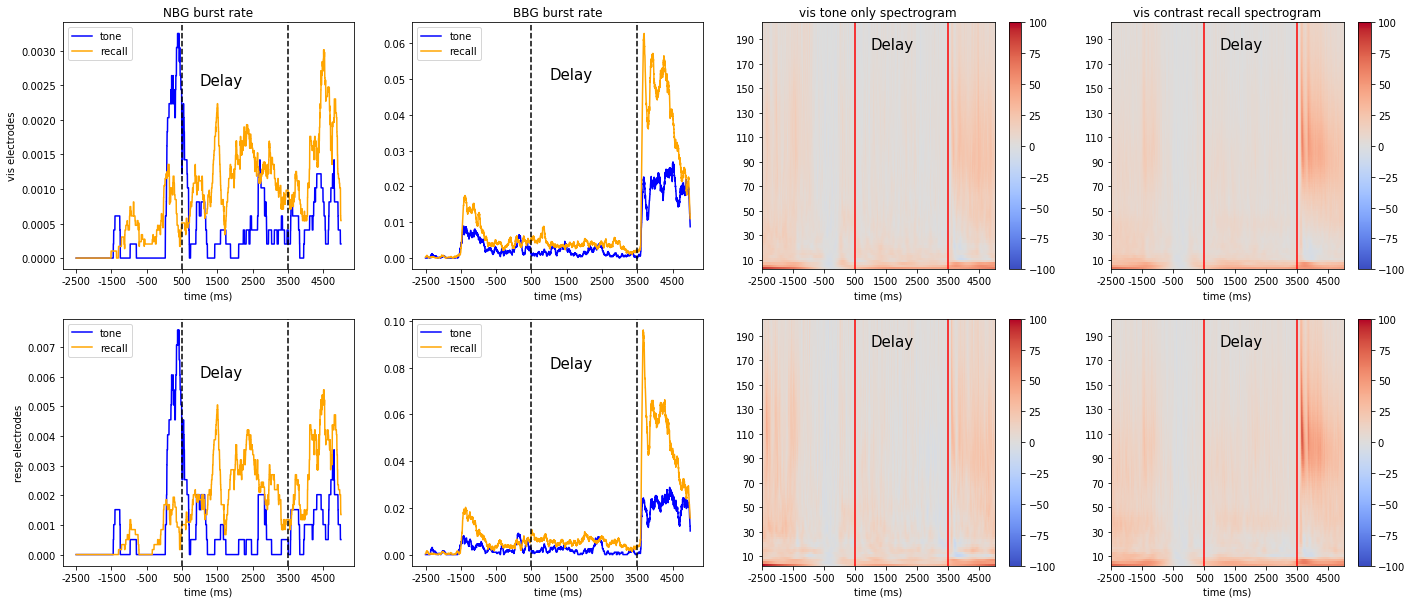

In [40]:
#~~~~~~~~~~~~plot results~~~~~~~~~~~~~~~~~~~~
# mean of all subjects all electrodes
fig, ax = plt.subplots(2,4, figsize = (24,10))
plt.setp(ax, xticks = np.arange(0,7501,1000), xticklabels = np.arange(-2500,5001,1000),
         xlabel = 'time (ms)')
ax[0,0].plot(mn_all_vis_br_NBG_tone, label = 'tone', color = 'blue')
ax[0,0].plot(mn_all_vis_br_NBG_recall, label = 'recall', color = 'orange')
ax[0,0].axvline(x=3000, color = 'k', linestyle = '--')
ax[0,0].axvline(x=6000, color = 'k', linestyle = '--')
ax[0,0].set_title('NBG burst rate')
ax[0,0].text(3500,0.0025,'Delay',fontsize = 15)
ax[0,0].legend()

ax[0,0].set_ylabel('vis electrodes')
ax[1,0].set_ylabel('resp electrodes')

ax[0,1].plot(mn_all_vis_br_BBG_tone, label = 'tone', color = 'blue')
ax[0,1].plot(mn_all_vis_br_BBG_recall, label = 'recall', color = 'orange')
ax[0,1].axvline(x=3000, color = 'k', linestyle = '--')
ax[0,1].axvline(x=6000, color = 'k', linestyle = '--')
ax[0,1].set_title('BBG burst rate')
ax[0,1].text(3500,0.05,'Delay',fontsize = 15)
ax[0,1].legend()

im3 = ax[0,2].pcolormesh(mn_all_vis_spect_tone, cmap = 'coolwarm', vmin = -100, vmax = 100)
plt.colorbar(im3, ax = ax[0,2])
ax[0,2].axvline(x=3000, color = 'r')
ax[0,2].axvline(x=6000, color = 'r')
ax[0,2].text(3500,90,'Delay',fontsize = 15);
ax[0,2].set_yticks(np.arange(4,104,10))
ax[0,2].set_yticklabels(np.arange(10,220,20))
ax[0,2].set_title('vis tone only spectrogram')

im4 = ax[0,3].pcolormesh(mn_all_vis_spect_recall, cmap = 'coolwarm', vmin = -100, vmax = 100)
plt.colorbar(im4, ax = ax[0,3])
ax[0,3].axvline(x=3000, color = 'r')
ax[0,3].axvline(x=6000, color = 'r')
ax[0,3].text(3500,90,'Delay',fontsize = 15);
ax[0,3].set_yticks(np.arange(4,104,10))
ax[0,3].set_yticklabels(np.arange(10,220,20))
ax[0,3].set_title('vis contrast recall spectrogram')

ax[1,0].plot(mn_all_resp_br_NBG_tone, label = 'tone', color = 'blue')
ax[1,0].plot(mn_all_resp_br_NBG_recall, label = 'recall', color = 'orange')
ax[1,0].axvline(x=3000, color = 'k', linestyle = '--')
ax[1,0].axvline(x=6000, color = 'k', linestyle = '--')
ax[1,0].text(3500,0.006,'Delay',fontsize = 15)
ax[1,0].legend()

ax[1,1].plot(mn_all_resp_br_BBG_tone, label = 'tone', color = 'blue')
ax[1,1].plot(mn_all_resp_br_BBG_recall, label = 'recall', color = 'orange')
ax[1,1].axvline(x=3000, color = 'k', linestyle = '--')
ax[1,1].axvline(x=6000, color = 'k', linestyle = '--')
ax[1,1].text(3500,0.08,'Delay',fontsize = 15)
ax[1,1].legend()

im7 = ax[1,2].pcolormesh(mn_all_resp_spect_tone, cmap = 'coolwarm', vmin = -100, vmax = 100)
plt.colorbar(im7, ax = ax[1,2])
ax[1,2].axvline(x=3000, color = 'r')
ax[1,2].axvline(x=6000, color = 'r')
ax[1,2].text(3500,90,'Delay',fontsize = 15);
ax[1,2].set_yticks(np.arange(4,104,10))
ax[1,2].set_yticklabels(np.arange(10,220,20))

im8 = ax[1,3].pcolormesh(mn_all_resp_spect_recall, cmap = 'coolwarm', vmin = -100, vmax = 100)
plt.colorbar(im8, ax = ax[1,3])
ax[1,3].axvline(x=3000, color = 'r')
ax[1,3].axvline(x=6000, color = 'r')
ax[1,3].text(3500,90,'Delay',fontsize = 15);
ax[1,3].set_yticks(np.arange(4,104,10));
ax[1,3].set_yticklabels(np.arange(10,220,20));

### 2. Group mean of subject means

Row 1: all visual cortex electrodes  
Row 2: all visual responsive electrodes

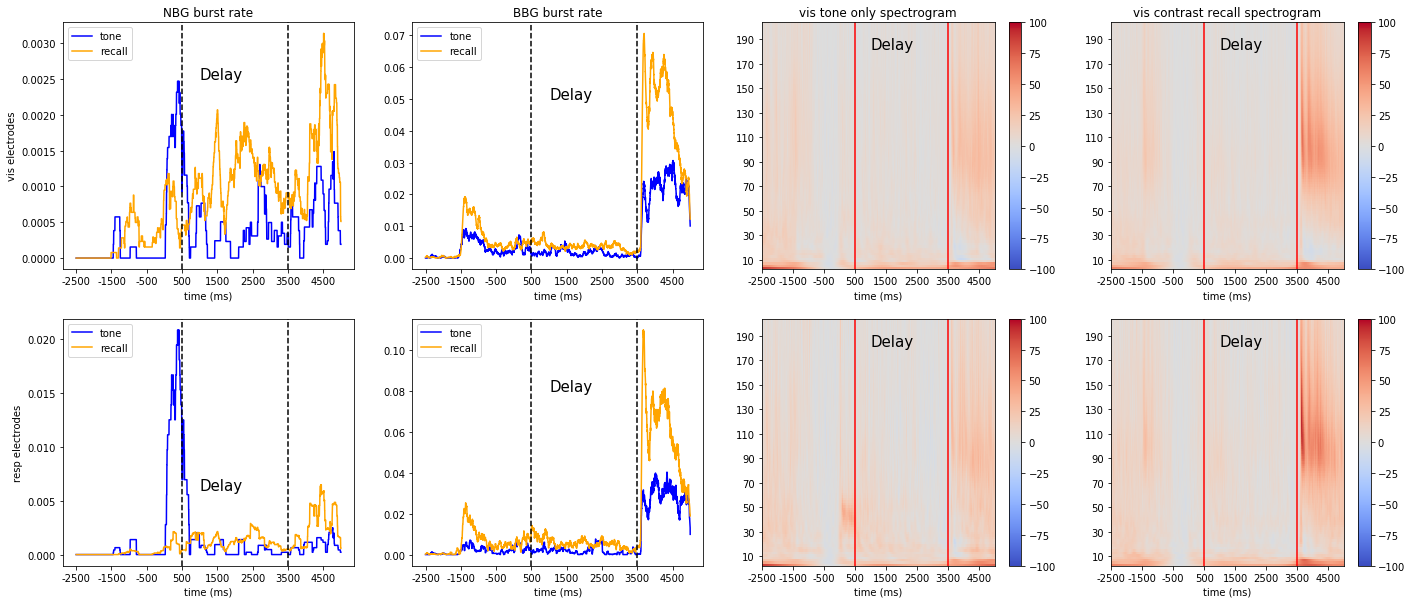

In [41]:
#~~~~~~~~~~~~plot results~~~~~~~~~~~~~~~~~~~~
# mean of all subjects all electrodes
fig, ax = plt.subplots(2,4, figsize = (24,10))
plt.setp(ax, xticks = np.arange(0,7501,1000), xticklabels = np.arange(-2500,5001,1000),
         xlabel = 'time (ms)')
ax[0,0].plot(mn_sj_vis_br_NBG_tone, label = 'tone', color = 'blue')
ax[0,0].plot(mn_sj_vis_br_NBG_recall, label = 'recall', color = 'orange')
ax[0,0].axvline(x=3000, color = 'k', linestyle = '--')
ax[0,0].axvline(x=6000, color = 'k', linestyle = '--')
ax[0,0].set_title('NBG burst rate')
ax[0,0].text(3500,0.0025,'Delay',fontsize = 15)
ax[0,0].legend()

ax[0,0].set_ylabel('vis electrodes')
ax[1,0].set_ylabel('resp electrodes')

ax[0,1].plot(mn_sj_vis_br_BBG_tone, label = 'tone', color = 'blue')
ax[0,1].plot(mn_sj_vis_br_BBG_recall, label = 'recall', color = 'orange')
ax[0,1].axvline(x=3000, color = 'k', linestyle = '--')
ax[0,1].axvline(x=6000, color = 'k', linestyle = '--')
ax[0,1].set_title('BBG burst rate')
ax[0,1].text(3500,0.05,'Delay',fontsize = 15)
ax[0,1].legend()

im3 = ax[0,2].pcolormesh(mn_sj_vis_spect_tone, cmap = 'coolwarm', vmin = -100, vmax = 100)
plt.colorbar(im3, ax = ax[0,2])
ax[0,2].axvline(x=3000, color = 'r')
ax[0,2].axvline(x=6000, color = 'r')
ax[0,2].text(3500,90,'Delay',fontsize = 15);
ax[0,2].set_yticks(np.arange(4,104,10))
ax[0,2].set_yticklabels(np.arange(10,220,20))
ax[0,2].set_title('vis tone only spectrogram')

im4 = ax[0,3].pcolormesh(mn_sj_vis_spect_recall, cmap = 'coolwarm', vmin = -100, vmax = 100)
plt.colorbar(im4, ax = ax[0,3])
ax[0,3].axvline(x=3000, color = 'r')
ax[0,3].axvline(x=6000, color = 'r')
ax[0,3].text(3500,90,'Delay',fontsize = 15);
ax[0,3].set_yticks(np.arange(4,104,10))
ax[0,3].set_yticklabels(np.arange(10,220,20))
ax[0,3].set_title('vis contrast recall spectrogram')

ax[1,0].plot(mn_sj_resp_br_NBG_tone, label = 'tone', color = 'blue')
ax[1,0].plot(mn_sj_resp_br_NBG_recall, label = 'recall', color = 'orange')
ax[1,0].axvline(x=3000, color = 'k', linestyle = '--')
ax[1,0].axvline(x=6000, color = 'k', linestyle = '--')
ax[1,0].text(3500,0.006,'Delay',fontsize = 15)
ax[1,0].legend()

ax[1,1].plot(mn_sj_resp_br_BBG_tone, label = 'tone', color = 'blue')
ax[1,1].plot(mn_sj_resp_br_BBG_recall, label = 'recall', color = 'orange')
ax[1,1].axvline(x=3000, color = 'k', linestyle = '--')
ax[1,1].axvline(x=6000, color = 'k', linestyle = '--')
ax[1,1].text(3500,0.08,'Delay',fontsize = 15)
ax[1,1].legend()

im7 = ax[1,2].pcolormesh(mn_sj_resp_spect_tone, cmap = 'coolwarm', vmin = -100, vmax = 100)
plt.colorbar(im7, ax = ax[1,2])
ax[1,2].axvline(x=3000, color = 'r')
ax[1,2].axvline(x=6000, color = 'r')
ax[1,2].text(3500,90,'Delay',fontsize = 15);
ax[1,2].set_yticks(np.arange(4,104,10))
ax[1,2].set_yticklabels(np.arange(10,220,20))

im8 = ax[1,3].pcolormesh(mn_sj_resp_spect_recall, cmap = 'coolwarm', vmin = -100, vmax = 100)
plt.colorbar(im8, ax = ax[1,3])
ax[1,3].axvline(x=3000, color = 'r')
ax[1,3].axvline(x=6000, color = 'r')
ax[1,3].text(3500,90,'Delay',fontsize = 15);
ax[1,3].set_yticks(np.arange(4,104,10));
ax[1,3].set_yticklabels(np.arange(10,220,20));

### plot individual burst rate and spectrogram

## YBE

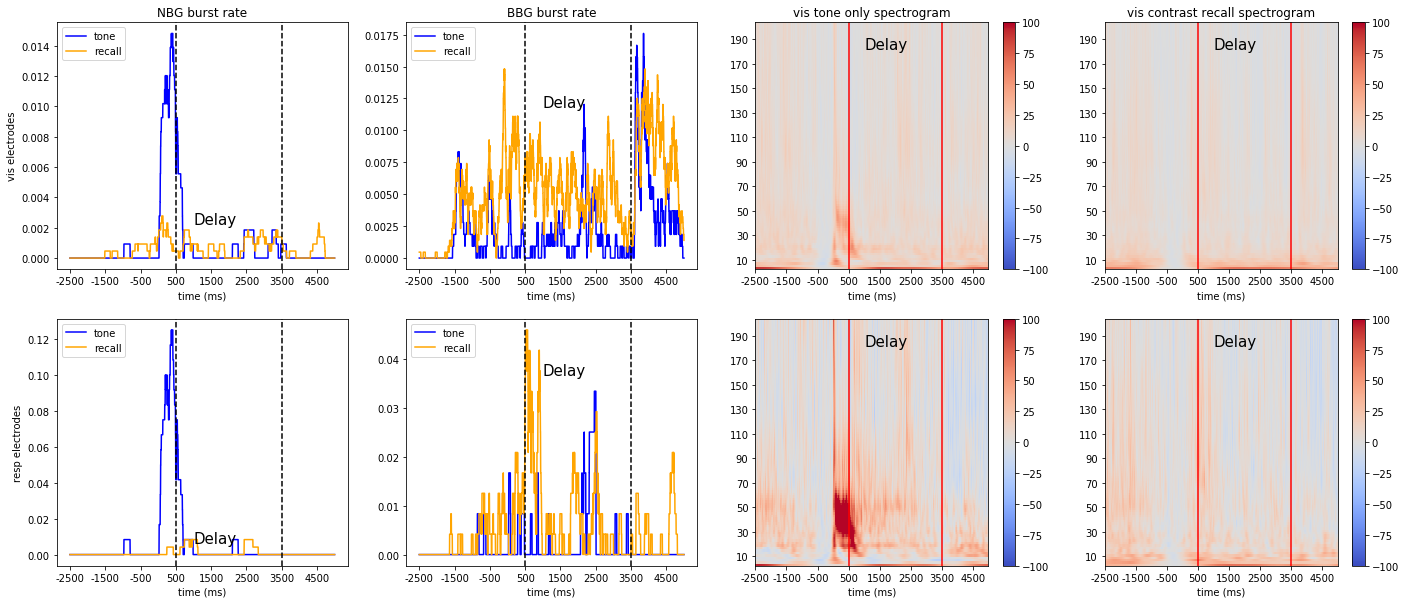

In [43]:
sbj_plot('YBE')

## YBG

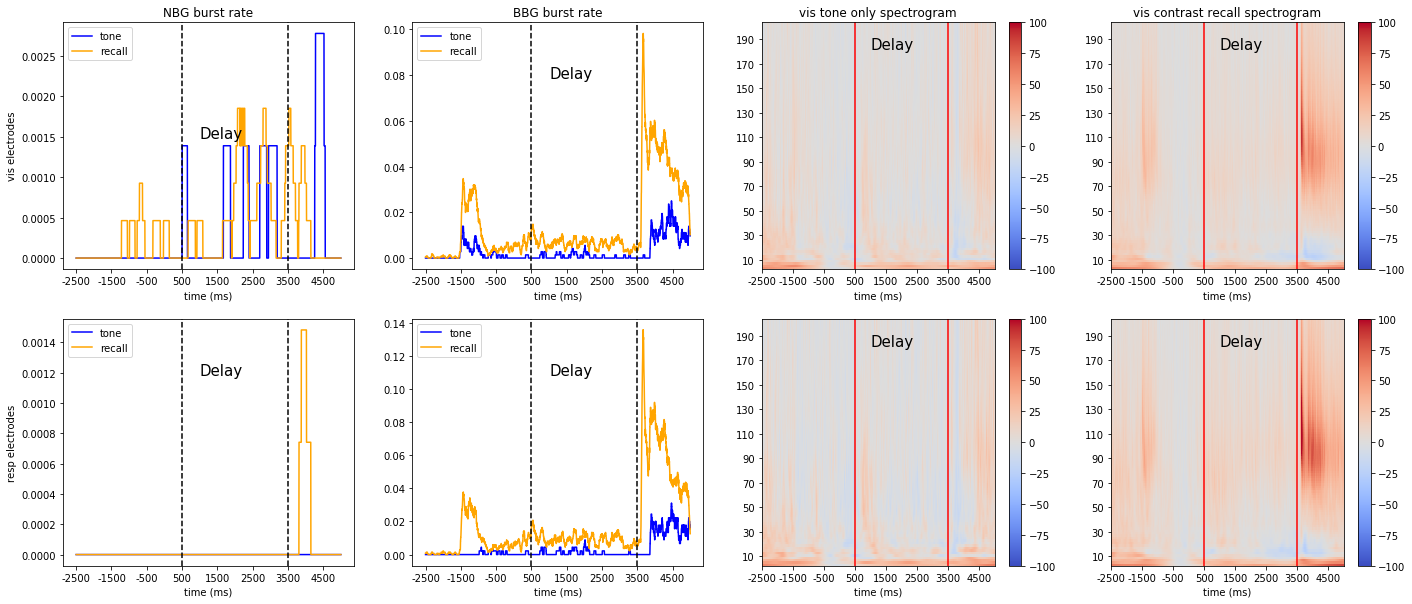

In [44]:
sbj_plot('YBG')

## YBI

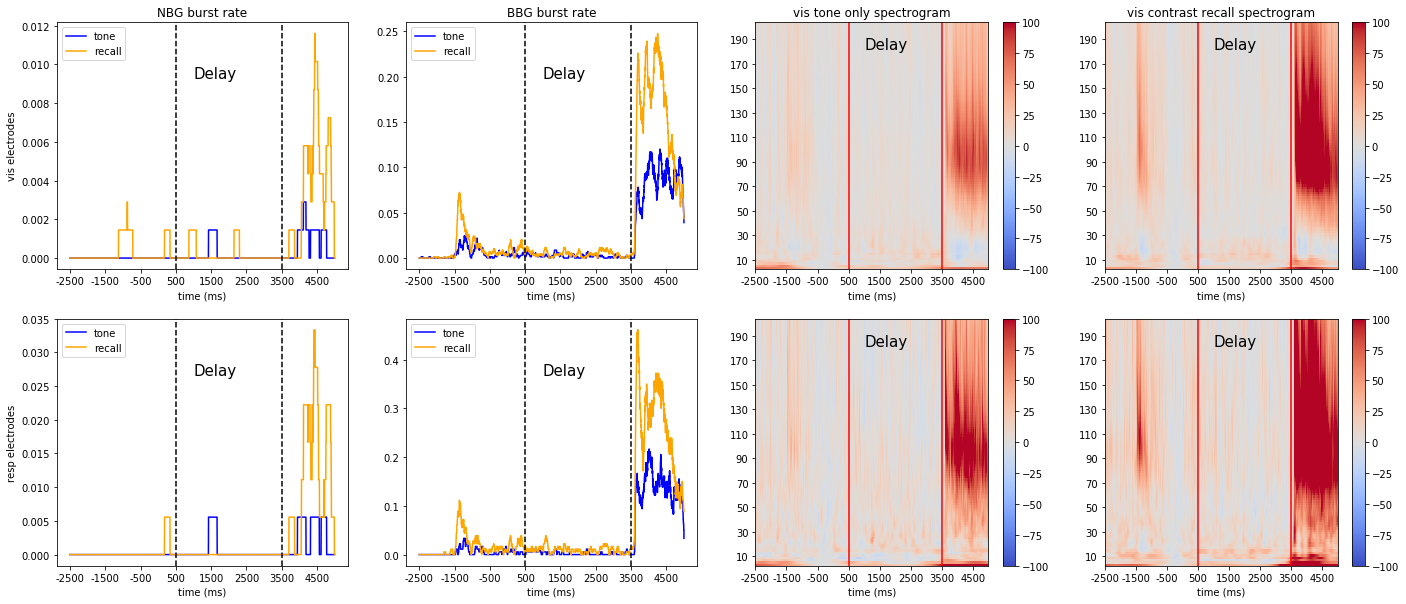

In [45]:
sbj_plot('YBI')

## YBJ

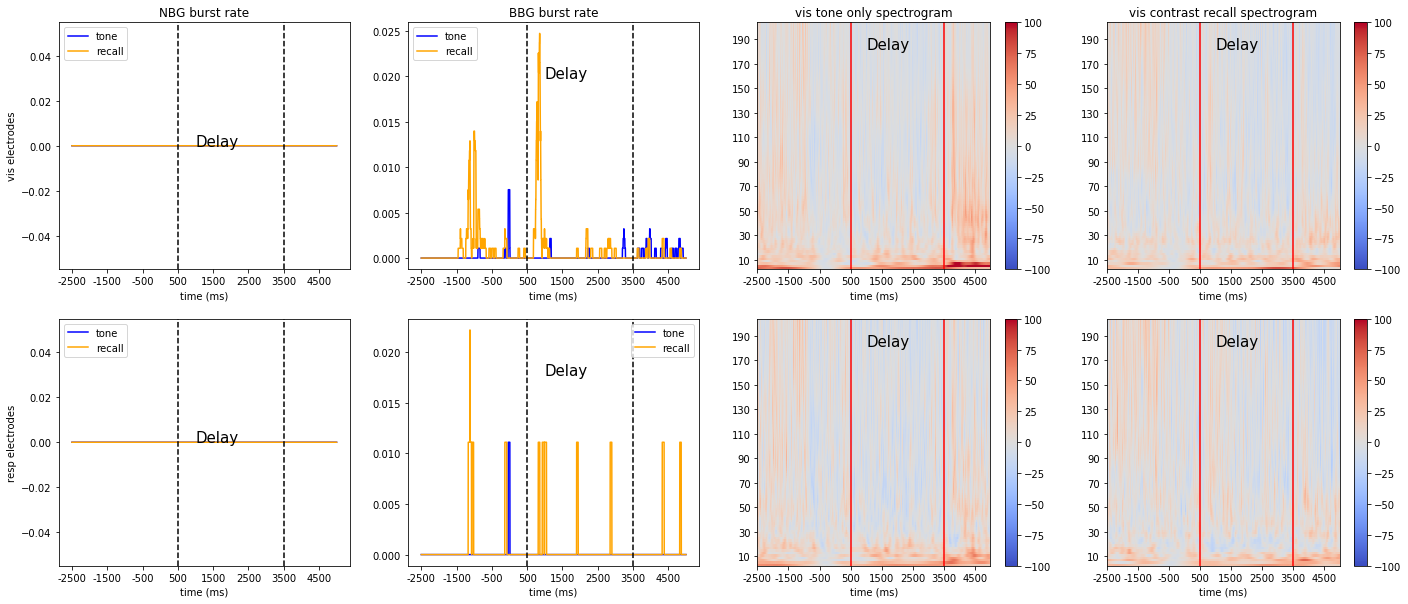

In [46]:
sbj_plot('YBJ')

## YBN

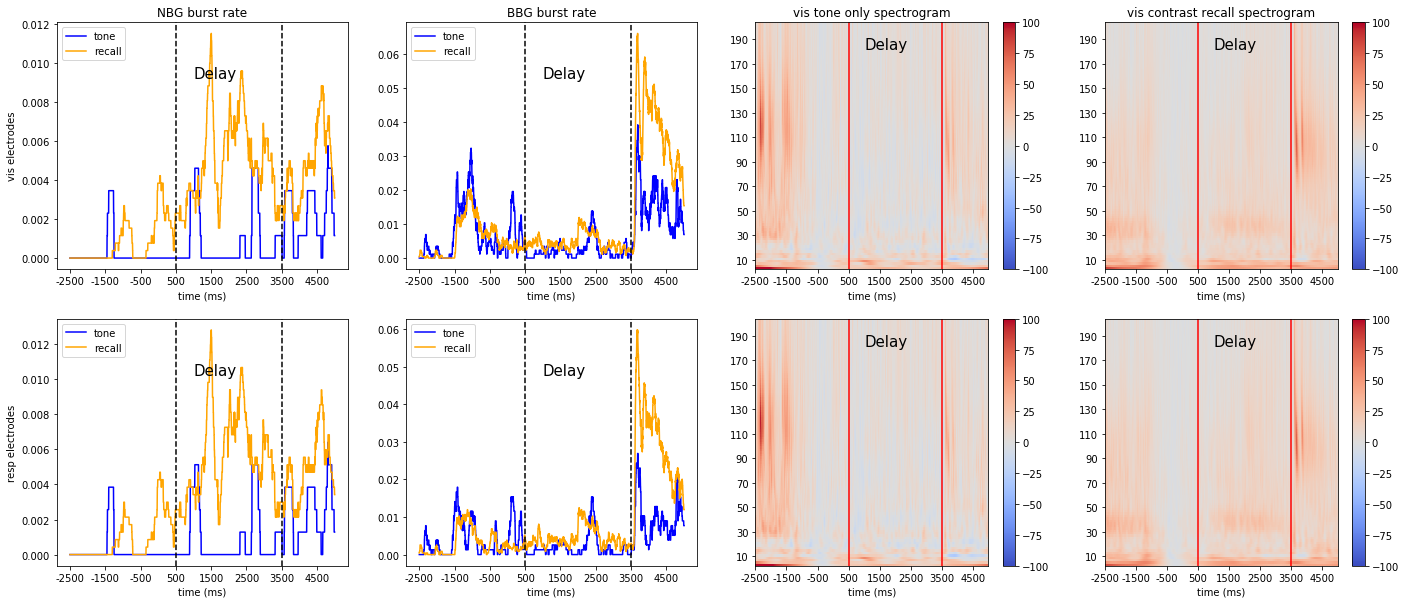

In [51]:
sbj_plot('YBN')

## YCP

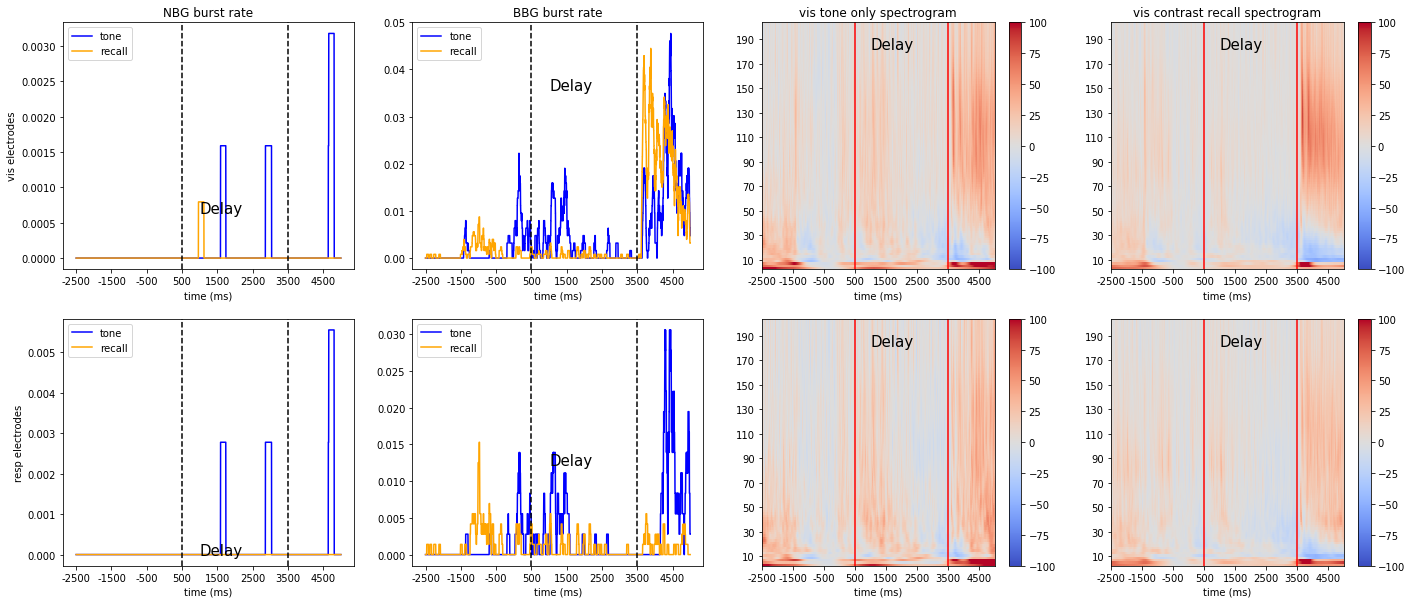

In [50]:
sbj_plot('YCP')